# Load the tools and the test data

In [1]:
# ! conda install "python==3.7.1"
# ! pip isntall cython
# ! pip install --no-deps "cooltools>=0.6.1"
# ! pip install fanc
# ! pip install ipykernel memory_profiler bioframe tqdm

In [2]:
import platform
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
plt.rcParams['font.size']=16
import seaborn as sns
import seaborn.objects as so
from matplotlib import style

import cooltools
import cooltools.lib.plotting
import bioframe
import cooler
import fanc
import fanc.plotting as fancplot

# Testing utils: 
from memory_profiler import memory_usage
import time
import timeit

import os
import subprocess

# helper functions
def sleep_before_after(func, sleep_sec=0.5):
    """ 
    Wrapper that allows to report background interpreter's memory consumption 
    for the first 5 time intervals (if increment is 0.1 abd sleep_sec=0.5):
    https://github.com/pythonprofilers/memory_profiler#api 
    """
    def _f(*args, **kwargs):
        time.sleep(sleep_sec)
        func(*args, **kwargs)
        time.sleep(sleep_sec)
    return _f

In [3]:
print(f"Cooltools v.{cooltools.__version__}")
print(f"FANC v.{fanc.__version__}")
print(f"System Platform: {platform.platform()}")
print(f"{psutil.cpu_count()} CPUs at {psutil.cpu_freq().current:.0f} GHz") 


Cooltools v.0.6.1
FANC v.0.9.27
System Platform: Linux-5.19.0-46-generic-x86_64-with-debian-bookworm-sid
24 CPUs at 2831 GHz


In [4]:
# Download the test data from Open2C.
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./data/')
print(cool_file)

./data/test.mcool


In [5]:
# Load a Hi-C map at a 1kb, 10k and 100k resolution from a cooler file.
# 1k is close to the highest resolution possible for Hi-C-like data so far.
# 10k is a regular resolution for Hi-C data.
# 100k is suitable for regular compartmental calling and analysis. 
resolution = 1000
clr1k   = cooler.Cooler(f'{cool_file}::/resolutions/{resolution}')
fanc_hic1k  = fanc.load(f'{cool_file}::/resolutions/{resolution}')

resolution = 10000
clr10k   = cooler.Cooler(f'{cool_file}::/resolutions/{resolution}')
fanc_hic10k  = fanc.load(f'{cool_file}::/resolutions/{resolution}')

resolution = 100000
clr100k   = cooler.Cooler(f'{cool_file}::/resolutions/{resolution}')
fanc_hic100k  = fanc.load(f'{cool_file}::/resolutions/{resolution}')

resolution = 1000000
clr1m   = cooler.Cooler(f'{cool_file}::/resolutions/{resolution}')
fanc_hic1m  = fanc.load(f'{cool_file}::/resolutions/{resolution}')

In [6]:
# Chromosomes 
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr1k.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93900000,chr2_p
1,chr2,93900000,242193529,chr2_q
2,chr17,0,25100000,chr17_p
3,chr17,25100000,83257441,chr17_q


In [7]:
view_df = pd.DataFrame({'chrom': clr1m.chromnames,
                        'start': 0,
                        'end': clr1m.chromsizes.values,
                        'name': clr1m.chromnames}
                      )

In [8]:
timings = [] #pd.DataFrame(columns=['test', 'tool', 'resolution', 'nproc', 'time', 'memory'])

# Testing individual tools

## 1. Expected

### Benchmark

In [9]:
# Time/processing benchmark for cooltools:
for resolution, clr in [(1000, clr1k), 
                        (10000, clr10k), 
                        (100000, clr100k),
                        (1000000, clr1m),
                        ]:
    for ncores in [1]: #[1, 2, 4]:
            
        t = timeit.Timer('cvd = cooltools.expected_cis(clr=clr, nproc=ncores)', globals=globals())
        
        # Get time: 
        time_sum = t.timeit(number=1)
        time_std = 0
    
        # Get memory:
        mem_usage = memory_usage(
                    (sleep_before_after(cooltools.expected_cis), [clr], 
                        dict( nproc=ncores)),
                    backend='psutil_pss', 
                    include_children=True,
                    interval=0.1)
        mem_usage = max(mem_usage) - mem_usage[4]
    
        # Store:
        timings.append( ('expected', 'cooltools', resolution, 1, time_sum, mem_usage) )

In [10]:
# Time/processing benchmark for FANC:
# Note that fanc stores the expected values once they are calculated; so we load new Hi-C object each time
for resolution in [1000, 10000, 100000, 1000000]:

    t = timeit.Timer('fanc_hic.expected_values()', setup="fanc_hic=fanc.load(f'{cool_file}::/resolutions/{resolution}')", globals=globals())
    
    # Get time: 
    time_sum = t.timeit(number=1)
    time_std = 0

    # Get memory:
    fanc_hic  = fanc.load(f'{cool_file}::/resolutions/{resolution}')
    mem_usage = memory_usage(
            (sleep_before_after(fanc_hic.expected_values)),
            backend='psutil_pss', 
            include_children=True,
            interval=0.1)
    mem_usage = max(mem_usage) - mem_usage[4]

    # Store:
    timings.append( ('expected', 'fanc', resolution, 1, time_sum, mem_usage) )

Expected 100% (76464322 of 76464322) |###| Elapsed Time: 0:03:06 Time:  0:03:06
Expected 100% (76464322 of 76464322) |###| Elapsed Time: 0:02:49 Time:  0:02:49
Expected 100% (24521334 of 24521334) |###| Elapsed Time: 0:00:50 Time:  0:00:50
Expected 100% (24521334 of 24521334) |###| Elapsed Time: 0:00:51 Time:  0:00:51
Expected 100% (3329916 of 3329916) |#####| Elapsed Time: 0:00:06 Time:  0:00:06
Expected 100% (3329916 of 3329916) |#####| Elapsed Time: 0:00:06 Time:  0:00:06
Expected 100% (52475 of 52475) |#########| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (52475 of 52475) |#########| Elapsed Time: 0:00:00 Time:  0:00:00


### Qualitative comparison of the output

#### Cooltools: expected

In [11]:
resolution = 1000

In [12]:
cvd = cooltools.expected_cis(
    clr=clr1k,
    smooth=False,
    aggregate_smoothed=False,
    nproc=4
)

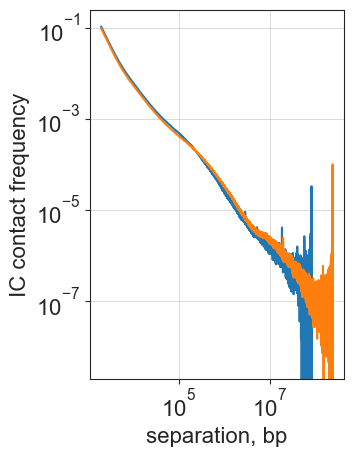

In [13]:
cvd['s_bp'] = cvd['dist'] * resolution
f, ax = plt.subplots(1,1)

for region in clr1k.chromnames[::-1]:
    ax.loglog(
        cvd['s_bp'].loc[cvd['region1']==region],
        cvd['balanced.avg'].loc[cvd['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

#### FANC: expected

In [14]:
intra_expected, intra_expected_chromosome, inter_expected = fanc_hic1k.expected_values()

Expected 100% (76464322 of 76464322) |###| Elapsed Time: 0:02:49 Time:  0:02:49


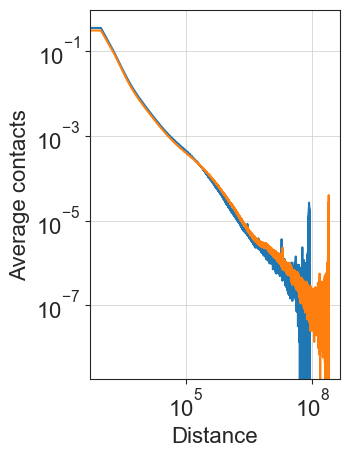

In [15]:
chrom= 'chr17'
fig, ax = plt.subplots()

for chrom in ['chr17', 'chr2']:
    bin_size = fanc_hic1k.bin_size
    distance = list(range(0,
                    bin_size * len(intra_expected_chromosome[chrom]), bin_size))

    # plot expected values
    plt.plot(distance, intra_expected_chromosome[chrom])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Distance")
    ax.set_ylabel("Average contacts")

ax.set_aspect(1.0)
ax.grid(lw=0.5)
plt.show()

## 2. Insulation and boundaries calling

### Benchmark

In [16]:
windows = [20_000]

In [17]:
for resolution, clr in [
                        (1000, clr1k), 
                        (10000, clr10k), 
                        ]:
    for ncores in [1]: #[1, 2, 4]:
        t = %timeit -o -r 1 cvd = cooltools.insulation(clr=clr, window_bp=windows, nproc=ncores)
        mem_usage = memory_usage(
                (sleep_before_after(cooltools.insulation), [clr], 
                    dict( window_bp=windows,
                          nproc=ncores)),
                backend='psutil_pss', 
                include_children=True,
                interval=0.1)
        mem_usage = max(mem_usage) - mem_usage[4]
        timings.append( ('insulation', 'cooltools', resolution, ncores, t.average, mem_usage) )

37.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
for resolution, fanc_hic in [
                        (1000, fanc_hic1k), 
                        (10000, fanc_hic10k),
                        ]:
    t = %timeit -o -r 1 cvd = fanc.InsulationScores.from_hic(fanc_hic, windows)
    mem_usage = memory_usage(
            (sleep_before_after(fanc.InsulationScores.from_hic), [fanc_hic, windows]),
            backend='psutil_pss', 
            include_children=True,
            interval=0.1)
    mem_usage = max(mem_usage) - mem_usage[4]
    timings.append( ('insulation', 'fanc', resolution, 1, t.average, mem_usage) )

INFO:fanc.architecture.domains:chr2 (1/2)
INFO:fanc.architecture.domains:chr17 (2/2)
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/architecture/domains.py:414: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
INFO:fanc.architecture.domains:chr2 (1/2)
INFO:fanc.architecture.domains:chr17 (2/2)


2min 17s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/architecture/domains.py:414: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
INFO:fanc.architecture.domains:chr2 (1/2)
INFO:fanc.architecture.domains:chr17 (2/2)
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/architecture/domains.py:414: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
INFO:fanc.architecture.domains:chr2 (1/2)
INFO:fanc.architecture.domains:chr17 (2/2)
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/architecture/domains.py:414: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
INFO:fanc.architecture.domains:chr2 (1/2)
INFO:fanc.architecture.domains:chr17 (2/2)


36.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/architecture/domains.py:414: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
INFO:fanc.architecture.domains:chr2 (1/2)
INFO:fanc.architecture.domains:chr17 (2/2)
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/architecture/domains.py:414: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)


### Qualitative comparison

#### cooltools: insulation

In [19]:
windows = [20_000]
clr = clr1k
resolution = 1000
insulation_table = cooltools.insulation(clr, windows)

In [20]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

(10500000.0, 12300000.0)

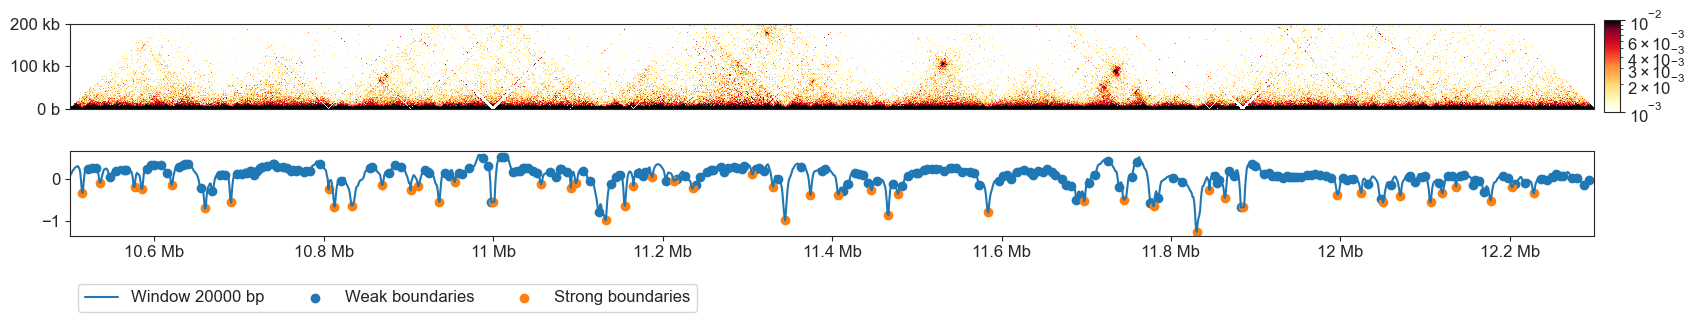

In [21]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 10_500_000
end = start+ 90*windows[0]
region = ('chr2', start, end)
norm = LogNorm(vmax=0.01, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

#### FANC: insulation

Note: 
- Use cooltools-like visualization for comparison

In [22]:
windows = [20_000]
resolution = 1000
insulation = fanc.InsulationScores.from_hic(fanc_hic1k, windows)
boundaries = fanc.Boundaries.from_insulation_score(insulation, window_size=20_000)

ins = insulation.score_regions(20_000)


INFO:fanc.architecture.domains:chr2 (1/2)
INFO:fanc.architecture.domains:chr17 (2/2)
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/architecture/domains.py:414: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/tools/matrix.py:79: UserWarning: Warning: converting a masked element to nan.
  delta[i] = np.ma.mean(x[down_slice] - x[i]) - np.ma.mean(x[up_slice] - x[i])
INFO:fanc.architecture.maxima_callers:Found 49206 raw peaks
INFO:fanc.architecture.domains:Found 23862 boundaries


In [23]:
fanc_insulation = pd.DataFrame( {'score': [x.score for x in ins.regions], 'region':[str(x) for x in ins.regions]} )

#Reconstruct region names:
fanc_insulation.loc[:, 'chrom'] = fanc_insulation.region.apply(lambda x: x.split(':')[0])
fanc_insulation.loc[:, 'start'] = fanc_insulation.region.apply(lambda x: int(x.split(':')[1].split('-')[0]))
fanc_insulation.loc[:, 'end']   = fanc_insulation.region.apply(lambda x: int(x.split(':')[1].split('-')[1]))

fanc_insulation.set_index('region', inplace=True)


In [24]:
import tqdm
# Add annotation of boundaries:
for boundary in tqdm.tqdm(boundaries.regions):
    score = boundary.score
    region = str(boundary)

    fanc_insulation.loc[region, 'boundary'] = score

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23862/23862 [00:16<00:00, 1482.64it/s]


(10500000.0, 12300000.0)

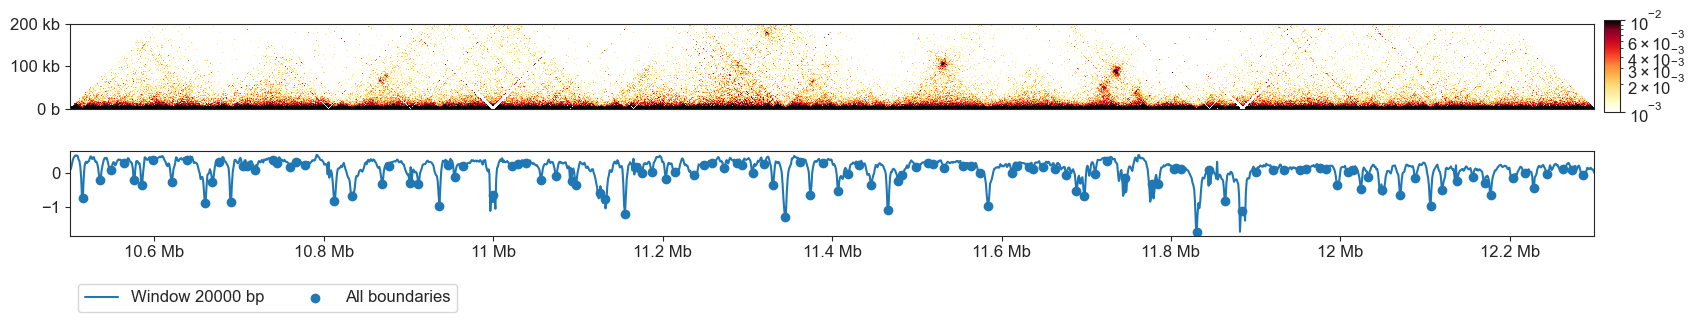

In [25]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 10_500_000
end = start+ 90*windows[0]
region = ('chr2', start, end)
norm = LogNorm(vmax=0.01, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(fanc_insulation, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'score'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary'])]
ins_ax.scatter(boundaries[['start', 'end']].mean(axis=1),
            boundaries[f'score'], label='All boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

## 3. Pileups

In [26]:
ctcf_peaks_file = cooltools.download_data("HFF_CTCF_binding", cache=True, data_dir='./data')

flank = 300_000
resolution = 10_000

# Prepare data for cooltools pileups:
clr = clr10k

sites = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')
sites['mid'] = (sites.end+sites.start)//2


# prepare data fro FANC aggregated analysis:
fanc_hic = fanc_hic10k

# Name the regions:
sites.loc[:, 'regions'] = sites.apply(lambda x: f'{x.chrom}:{x.start}-{x.end}', axis=1)

# Construct FANC region table:
rt = fanc.regions.RegionsTable()

regions = []
for i, r in sites.iterrows():
    r = fanc.GenomicRegion(chromosome=r.chrom, start=r.start, end=r.end)
    regions.append(r)
rt.add_regions(regions)

### Benchmark

In [27]:
for resolution, clr in [
                        (1000, clr1k), 
                        (10000, clr10k), 
                        (100000, clr100k), 
                        ]:
    for ncores in [1]: #[1, 2, 4]:
        t = %timeit -o -r 1 cvd = cooltools.pileup(clr=clr, features_df=sites, flank=flank, nproc=ncores)
        mem_usage = memory_usage(
                (sleep_before_after(cooltools.pileup), [clr, sites], 
                    dict( flank=flank,
                          nproc=ncores)),
                backend='psutil_pss', 
                include_children=True,
                interval=0.1)
        mem_usage = max(mem_usage) - mem_usage[4]
        timings.append( ('pileups', 'cooltools', resolution, ncores, t.average, mem_usage) )

34.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
659 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
for resolution, fanc_hic in [
                        # (1000, fanc_hic1k), # Bottleneck at 37% for unknown reason; freezes for too long time at 1 Kb
                        (10000, fanc_hic10k), # Also has bottleneck at 37%, but finishes in reasonable time
                        (100000, fanc_hic100k),
                        ]:
    
    t = %timeit -o -r 1 cvd = fanc.AggregateMatrix.from_center(fanc_hic, rt, window=flank, oe=False)
    
    mem_usage = memory_usage(
            (sleep_before_after(fanc.AggregateMatrix.from_center), [fanc_hic, rt], 
                    dict( window=flank, oe=False)),
            backend='psutil_pss', 
            include_children=True,
            interval=0.1)
    mem_usage = max(mem_usage) - mem_usage[4]
    
    timings.append( ('pileups', 'fanc', resolution, 1, t.average, mem_usage) )

INFO:fanc.architecture.aggregate:Checking region pair validity...
INFO:fanc.architecture.aggregate:12/5778 region pairs are invalid
Matrices 100% (5766 of 5766) |###########| Elapsed Time: 0:01:05 Time:  0:01:05
INFO:fanc.architecture.aggregate:Checking region pair validity...
INFO:fanc.architecture.aggregate:12/5778 region pairs are invalid
Matrices 100% (5766 of 5766) |###########| Elapsed Time: 0:01:05 Time:  0:01:05


1min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


INFO:fanc.architecture.aggregate:Checking region pair validity...
INFO:fanc.architecture.aggregate:12/5778 region pairs are invalid
Matrices 100% (5766 of 5766) |###########| Elapsed Time: 0:01:07 Time:  0:01:07
INFO:fanc.architecture.aggregate:Checking region pair validity...
INFO:fanc.architecture.aggregate:12/5778 region pairs are invalid
Matrices 100% (5766 of 5766) |###########| Elapsed Time: 0:00:27 Time:  0:00:27
INFO:fanc.architecture.aggregate:Checking region pair validity...
INFO:fanc.architecture.aggregate:12/5778 region pairs are invalid
Matrices 100% (5766 of 5766) |###########| Elapsed Time: 0:00:27 Time:  0:00:27


32.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


INFO:fanc.architecture.aggregate:Checking region pair validity...
INFO:fanc.architecture.aggregate:12/5778 region pairs are invalid
Matrices 100% (5766 of 5766) |###########| Elapsed Time: 0:00:27 Time:  0:00:27


### Qualitative comparison

In [29]:
resolution = 10_000
flank = 300_000

clr = clr10k
fanc_hic = fanc_hic10k

#### cooltools: pileups

In [30]:
stack = cooltools.pileup(clr, sites, flank=flank).T
# Mirror reflect snippets when the feature is on the opposite strand
mask = np.array(sites.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]

# Aggregate. Note that some pixels might be converted to NaNs after IC, thus we aggregate by nanmean:
mtx = np.nanmean(stack, axis=2)

/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


Text(0, 0.5, 'relative position, kbp')

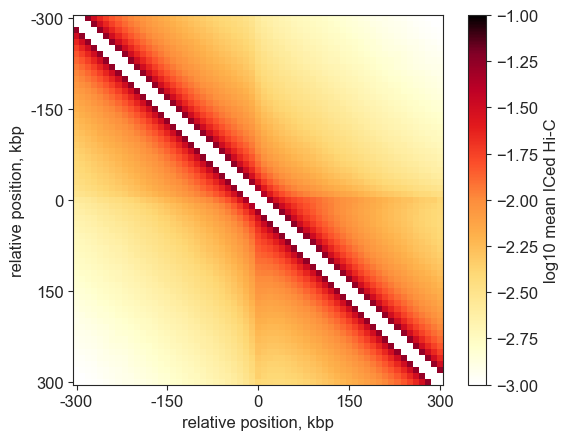

In [31]:
plt.imshow(
    np.log10(mtx),
    vmin = -3,
    vmax = -1,
    cmap='fall',
    interpolation='none')

plt.colorbar(label = 'log10 mean ICed Hi-C')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

#### FANC: pileups

In [32]:
fixed_am = fanc.AggregateMatrix.from_center(fanc_hic, 
                                            rt,
                                            window=flank, 
                                            oe=False)


INFO:fanc.architecture.aggregate:Checking region pair validity...
INFO:fanc.architecture.aggregate:12/5778 region pairs are invalid
Matrices 100% (5766 of 5766) |###########| Elapsed Time: 0:01:06 Time:  0:01:06


In [33]:
# fixed_am.components()[0]

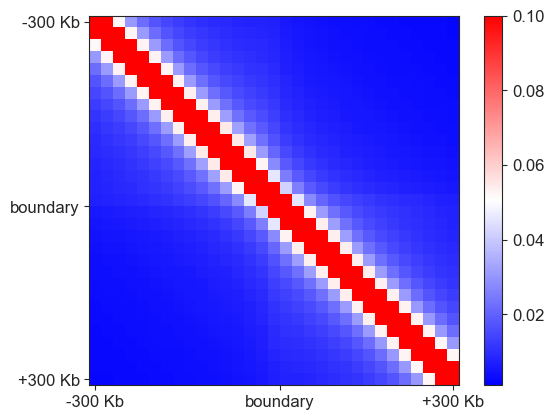

In [34]:
ax = fancplot.aggregate_plot(fixed_am, vmin=0.001, vmax=0.1,
                             labels=['-300 Kb', 'boundary', '+300 Kb'])

## 4. Compartments

In [35]:
### Prepare the data for compartments calling: 

## fasta sequence is required for calculating binned profile of GC conent
if not os.path.isfile('./hg38.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget --progress=bar:force:noscroll https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz', shell=True)
    subprocess.call('gunzip hg38.fa.gz', shell=True)

hg38_genome = bioframe.load_fasta('./hg38.fa');

resolution = 100000
clr = clr100k
bins = clr.bins()[:]

gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
gc_cov.to_csv('hg38_gc_cov_100kb.tsv',index=False,sep='\t')

resolution = 1000000
clr = clr1m
bins = clr.bins()[:]

gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
gc_cov.to_csv('hg38_gc_cov_1mb.tsv',index=False,sep='\t')

### Benchmark

Note: 
- Pre-calculate GC-content for the genome for cooltools, which seems to be unnecessary for FANC

In [36]:
ncores = 1
for resolution, clr in [
                        (100000, clr100k), 
                        (1000000, clr1m), 
                        ]:
    
    bins = clr.bins()[:]
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
    
    t = %timeit -o -r 1 cis_eigs = cooltools.eigs_cis(clr, gc_cov, view_df=view_df, n_eigs=1)
    
    mem_usage = memory_usage(
            (sleep_before_after(cooltools.eigs_cis), [clr, gc_cov], 
                dict( view_df=view_df, n_eigs=1)),
            backend='psutil_pss', 
            include_children=True,
            interval=0.1)
    mem_usage = max(mem_usage) - mem_usage[4]
    
    timings.append( ('compartments', 'cooltools', resolution, ncores, t.average, mem_usage) )

596 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
62.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [37]:
for resolution, fanc_hic in [
                        (100000, fanc_hic100k), 
                        (1000000, fanc_hic1m),
                        ]:
    t = %timeit -o -r 1 ab = fanc.ABCompartmentMatrix.from_hic(fanc_hic)
    
    mem_usage = memory_usage(
            (sleep_before_after(fanc.ABCompartmentMatrix.from_hic), [fanc_hic]),
            backend='psutil_pss', 
            include_children=True,
            interval=0.1)
    mem_usage = max(mem_usage) - mem_usage[4]
    
    timings.append( ('compartments', 'fanc', resolution, 1, t.average, mem_usage) )

Expected 100% (3329916 of 3329916) |#####| Elapsed Time: 0:00:06 Time:  0:00:06
AB   0% (0 of 2) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:04 Time:  0:00:04
Buffers 100% (8 of 8) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (3249290 of 3249290) |#####| Elapsed Time: 0:00:08 Time:  0:00:08
AB   0% (0 of 2) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:04 T

54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


AB   0% (0 of 2) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:05 Time:  0:00:05
Buffers 100% (8 of 8) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (3249290 of 3249290) |#####| Elapsed Time: 0:00:08 Time:  0:00:08
Expected 100% (52475 of 52475) |#########| Elapsed Time: 0:00:00 Time:  0:00:00
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:00 Time:  0:00:00
Buffers 100% (1 of 1) |##################| Elapsed Time: 0:00:00 

746 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:00 Time:  0:00:00
Buffers 100% (1 of 1) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (31681 of 31681) |#########| Elapsed Time: 0:00:00 Time:  0:00:00


### Qualitative comparison

#### cooltools: compartments

In [38]:
clr = clr100k

bins = clr.bins()[:]
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)    

In [39]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom', 'start', 'end', 'E1']]

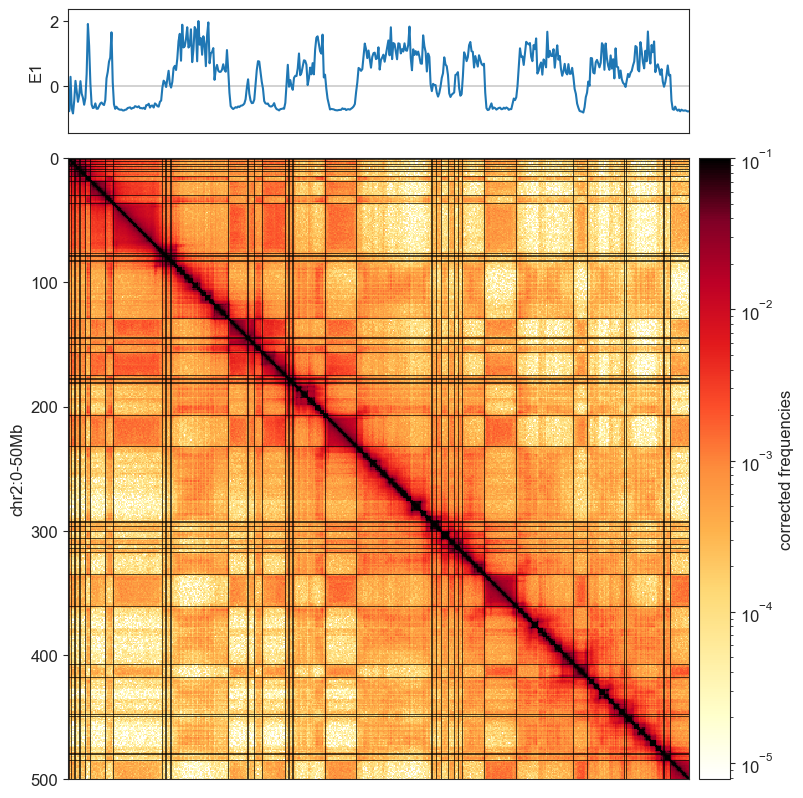

In [40]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall'
);
plt.axis([0,500,500,0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chr2:0-50Mb')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
ax1.plot([0,500],[0,0],'k',lw=0.25)
ax1.plot( eigenvector_track['E1'].values, label='E1')

ax1.set_ylabel('E1')
ax1.set_xticks([]);


for i in np.where(np.diff( (cis_eigs[1]['E1']>0).astype(int)))[0]:
    ax.plot([0, 500],[i,i],'k',lw=0.5)
    ax.plot([i,i],[0, 500],'k',lw=0.5)

#### FANC: compartments

Note: 
- FANC visualization produces error
- cooltools-like visualization shows that EVs are more smooth than cooltools ones

In [41]:
fanc_hic = fanc_hic100k

In [42]:
ab = fanc.ABCompartmentMatrix.from_hic(fanc_hic)

AB   0% (0 of 2) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:04 Time:  0:00:04
Buffers 100% (8 of 8) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (3249290 of 3249290) |#####| Elapsed Time: 0:00:08 Time:  0:00:08


In [43]:
ab_chr17 = ab.matrix(('chr17', 'chr17'))

In [44]:
# ab_chr17

'NoneType' object has no attribute 'figure'


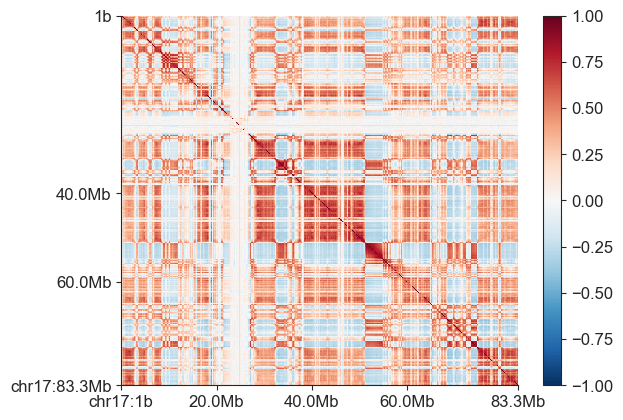

In [45]:
try:
    fig, ax = plt.subplots()
    mp = fancplot.SquareMatrixPlot(ab, ax=ax,
                           norm='lin', colormap='RdBu_r',
                           vmin=-1, vmax=1,
                           draw_minor_ticks=False)
    mp.plot('chr17')
except Exception as e:
    print(e)

In [46]:
ev = ab.eigenvector()

In [47]:
gc_ev = ab.eigenvector(genome='./hg38.fa', force=True)

INFO:fanc.architecture.compartments:Using GC content to orient eigenvector...
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/Bio/SeqUtils/__init__.py:146: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  BiopythonDeprecationWarning,


In [48]:
gc_ev

array([-0.02033307, -0.02074176, -0.00114913, ...,  0.04366573,
        0.04433912, -0.        ])

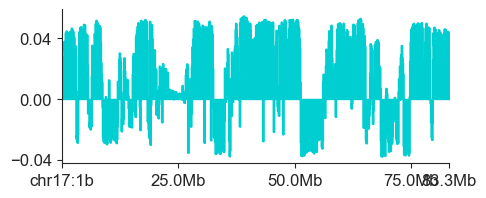

In [49]:
fig, ax = plt.subplots(figsize=(5, 2))
lp = fancplot.LinePlot(ab, colors=['darkturquoise'])
lp.plot('chr17')
plt.show()

##### cooltools-like visualization

In [50]:
clr = clr100k

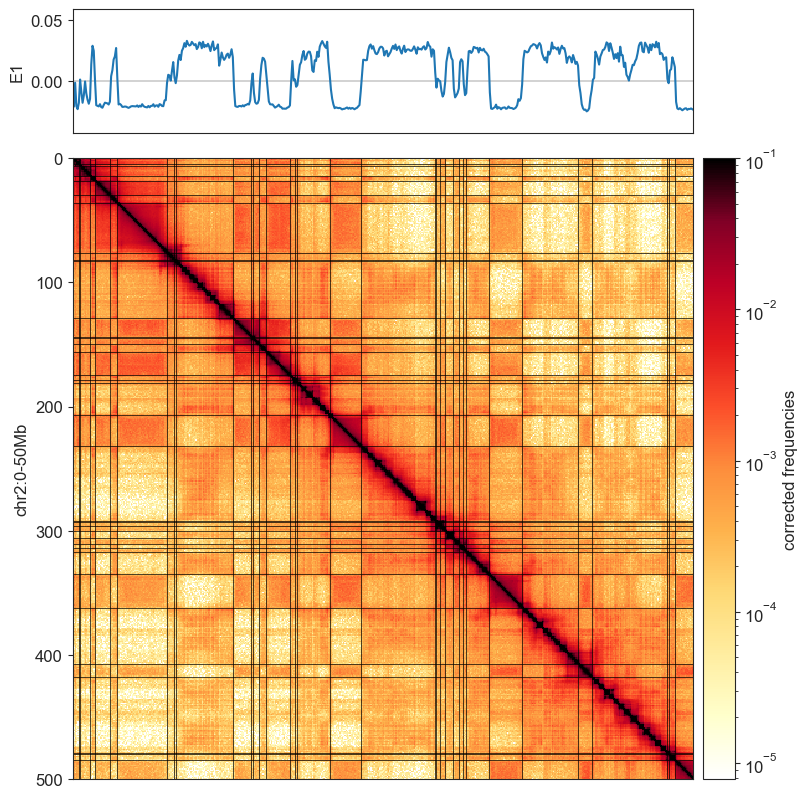

In [51]:
f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall'
);
plt.axis([0,500,500,0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chr2:0-50Mb')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
ax1.plot([0,500],[0,0],'k',lw=0.25)
ax1.plot( gc_ev, label='E1')

ax1.set_ylabel('E1')
ax1.set_xticks([]);


for i in np.where(np.diff( (gc_ev>0).astype(int)))[0]:
    ax.plot([0, 500],[i,i],'k',lw=0.5)
    ax.plot([i,i],[0, 500],'k',lw=0.5)

## 5. Saddles

### Benchmark

Notes: 
- Pre-calculate compartments and observed over expected before the saddle for both FANC and cooltools

In [52]:
ncores = 1

Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 5 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

for resolution, clr in [(100000, clr100k), 
                        (1000000, clr1m), 
                        ]:
    
    cvd = cooltools.expected_cis(
        clr=clr,
        view_df=view_df,
    )
    
    bins = clr.bins()[:]
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
    cis_eigs = cooltools.eigs_cis(clr, gc_cov, view_df=view_df, n_eigs=1)
    eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
    
    t = %timeit -o -r 1 interaction_sum, interaction_count =  cooltools.saddle(clr, cvd, eigenvector_track, 'cis', n_bins=N_GROUPS, qrange=(Q_LO,Q_HI), view_df=view_df)
    
    mem_usage = memory_usage(
            (sleep_before_after(cooltools.saddle), [clr, cvd, eigenvector_track, 'cis'], 
                dict( n_bins=N_GROUPS, qrange=(Q_LO,Q_HI), view_df=view_df )),
            backend='psutil_pss', 
            include_children=True,
            interval=0.1)
    mem_usage = max(mem_usage) - mem_usage[4]
    
    timings.append( ('saddle', 'cooltools', resolution, ncores, t.average, mem_usage) )

281 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
57.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [53]:
for resolution, fanc_hic in [
                        (100000, fanc_hic100k), 
                        (1000000, fanc_hic1m),
                        ]:

    ab = fanc.ABCompartmentMatrix.from_hic(fanc_hic) # Also calculated the OOE
    
    t = %timeit -o -r 1 profile, cutoffs = ab.enrichment_profile(fanc_hic, genome='./hg38.fa')
    
    mem_usage = memory_usage(
            (sleep_before_after(ab.enrichment_profile), [fanc_hic], dict( genome='./hg38.fa' )),
            backend='psutil_pss', 
            include_children=True,
            interval=0.1)
    mem_usage = max(mem_usage) - mem_usage[4]
    
    timings.append( ('saddle', 'fanc', resolution, 1, t.average, mem_usage) )

AB   0% (0 of 2) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:04 Time:  0:00:04
Buffers 100% (8 of 8) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (3249290 of 3249290) |#####| Elapsed Time: 0:00:08 Time:  0:00:08
INFO:fanc.architecture.compartments:Generating profile...
INFO:fanc.architecture.compartments:Using GC content to orient eigenvector...
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/Bio/SeqUtils/__init__.py:146: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  BiopythonDeprecationWarning,
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: Runti

18.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


INFO:fanc.architecture.compartments:Generating profile...
INFO:fanc.architecture.compartments:Returning pre-calculated eigenvector!
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:00 Time:  0:00:00
Buffers 100% (1 of 1) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (31681 of 31681) |#########| Elapsed Time: 0:00:00 Time:  0:00:00
INFO:fanc.architecture.compartments:Generating profile...
INFO:fanc.architecture.compartments:Using GC content to orient eigenvector...
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/Bio/SeqUtils/__init__.py:146: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  BiopythonDeprecationWarning,
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
INFO:fanc.architecture.compartments:Generating profile.

244 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


INFO:fanc.architecture.compartments:Generating profile...
INFO:fanc.architecture.compartments:Returning pre-calculated eigenvector!


### Qualitative comparison

#### cooltools: saddles

In [54]:
clr = clr100k

In [55]:
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=view_df,
)

bins = clr.bins()[:]
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
cis_eigs = cooltools.eigs_cis(clr, gc_cov, view_df=view_df, n_eigs=1)
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]

In [56]:
Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 5 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

In [57]:
interaction_sum, interaction_count =  cooltools.saddle(
        clr,
        cvd,
        eigenvector_track,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

In [58]:
import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    # Old version
    # hist = np.bincount(x, minlength=len(binedges) + 1)

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

#     # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["ax_cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        print('cbar')

        cb = plt.colorbar(img, format=MinOneMaxFormatter(), cax=grid["ax_cbar"], **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    grid['ax_heatmap'].grid(False)
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)

    return grid

cbar


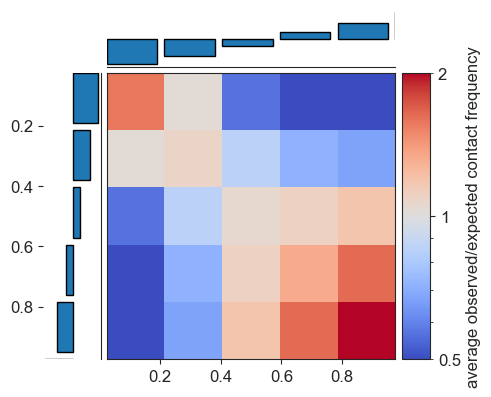

In [59]:
saddleplot(eigenvector_track,
           interaction_sum/interaction_count,
           N_GROUPS,
           qrange=(Q_LO,Q_HI),
           cbar_kws={'label':'average observed/expected contact frequency'}
          );

#### FANC: saddles

In [60]:
fanc_hic = fanc_hic100k

In [61]:
ab = fanc.ABCompartmentMatrix.from_hic(fanc_hic)
profile, cutoffs = ab.enrichment_profile(fanc_hic, genome='./hg38.fa')

AB   0% (0 of 2) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: RuntimeWarning: invalid value encountered in double_scalars
  return (float(self._series.count) * self.bias) / self.expected
AB 100% (2 of 2) |#######################| Elapsed Time: 0:00:04 Time:  0:00:04
Buffers 100% (8 of 8) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
Expected 100% (3249290 of 3249290) |#####| Elapsed Time: 0:00:08 Time:  0:00:08
INFO:fanc.architecture.compartments:Generating profile...
INFO:fanc.architecture.compartments:Using GC content to orient eigenvector...
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/Bio/SeqUtils/__init__.py:146: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  BiopythonDeprecationWarning,
/home/agalicina/anaconda3/envs/test_fanc/lib/python3.7/site-packages/fanc/compatibility/cooler.py:186: Runti

In [62]:
profile

array([[ 1.14881348,  1.10093266,  0.39813988, -0.17480959, -0.39092231],
       [ 1.10093266,  0.81880115,  0.38519596, -0.10297028, -0.26686411],
       [ 0.39813988,  0.38519596,  0.32166992,  0.07382459, -0.13781501],
       [-0.17480959, -0.10297028,  0.07382459,         nan,  0.41633315],
       [-0.39092231, -0.26686411, -0.13781501,  0.41633315,  0.95100529]])

In [63]:
cutoffs

array([ 0.05459893,  0.02807634,  0.02013059,  0.00194094, -0.01952203])

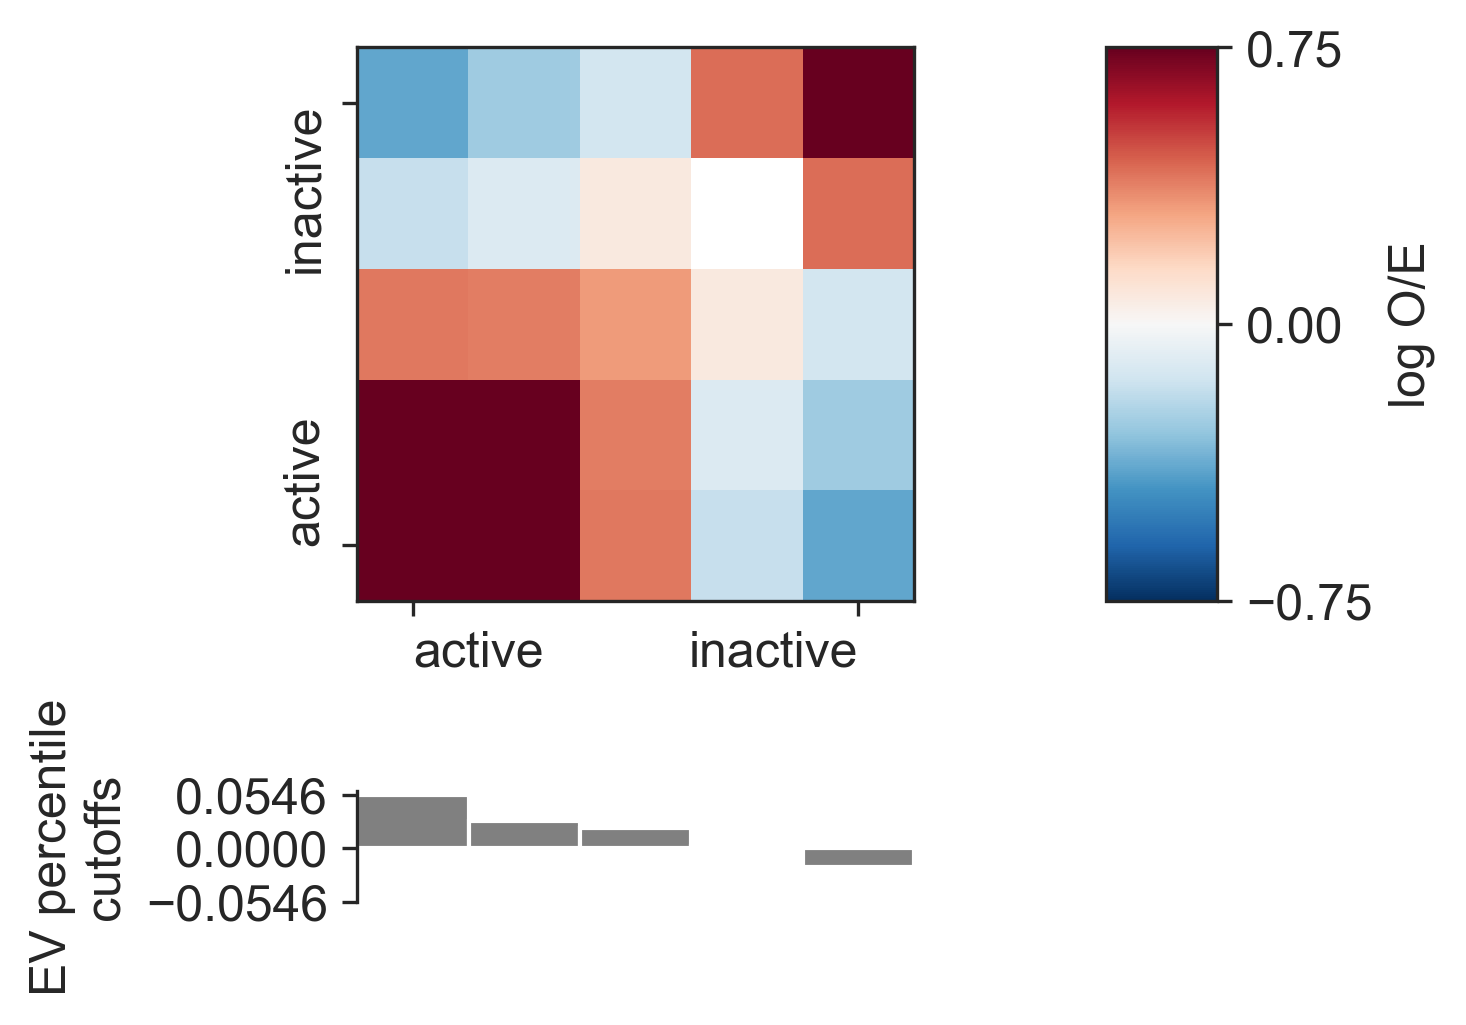

In [64]:
fig, axes = fancplot.saddle_plot(profile, cutoffs)

## 6. Dots (incomplete due to FANC error)

### Benchmark impossible
Note: 
- Running FANC produces unknown error on cooltools sample file; not reporting the final timing

### Qualitative comparison

#### cooltools: dots

In [65]:
clr = clr10k

In [66]:
# intra-arm expected
expected = cooltools.expected_cis(
    clr,
    nproc=4,
)

In [67]:
dots_df = cooltools.dots(
    clr,
    expected=expected,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:convolving 192 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 192 tiles
INFO:root:Done building histograms in 12.156 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 192 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 192 tiles
INFO:root:Done extracting enriched pixels in 7.162 sec ...
INFO:root:Begin post-processing of 15316 filtered pixels
INFO:root:preparing to extract needed q-values ...
INFO:root:clustering enriched pixels in region: chr17
INFO:root:detected 1250 clusters of 3.23+/-2.91 size
INFO:root:clustering enriched pixels in region: chr2
INFO:root:detected 3662 clusters of 3.08+/-2.81 size
INFO:root:Clustering is complete
INFO:root:filtered 3165 out of 4912 centroids to reduce the number of false-positives


In [68]:
dots_df

,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,region,cstart1,cstart2,c_label,c_size,region1,region2
0,chr17,51290000,51300000,chr17,54890000,54900000,35,11.411505,15.893953,11.674285,...,2.886680e-03,6.171605e-05,4.202044e-05,chr17,5.128000e+07,5.489500e+07,0,2,chr17,chr17
1,chr17,50540000,50550000,chr17,51150000,51160000,35,12.533179,14.884843,11.285667,...,2.886680e-03,6.171605e-05,4.249326e-07,chr17,5.054000e+07,5.115000e+07,2,1,chr17,chr17
2,chr17,50780000,50790000,chr17,50950000,50960000,568,102.309406,171.684829,106.741677,...,1.914538e-96,2.812989e-177,2.269674e-222,chr17,5.077714e+07,5.095857e+07,3,7,chr17,chr17
3,chr17,51460000,51470000,chr17,54890000,54900000,30,8.848270,10.883273,7.511642,...,4.343107e-03,2.699871e-06,2.803288e-03,chr17,5.146000e+07,5.488500e+07,4,2,chr17,chr17
4,chr17,51160000,51170000,chr17,54890000,54900000,30,7.243432,12.219899,7.169373,...,4.343107e-03,2.699871e-06,1.257422e-08,chr17,5.116500e+07,5.489000e+07,5,2,chr17,chr17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,chr2,156890000,156900000,chr2,157050000,157060000,191,66.661991,72.147215,75.125985,...,3.193567e-24,2.982908e-24,2.924052e-24,chr2,1.568956e+08,1.570422e+08,3653,9,chr2,chr2
3161,chr2,156430000,156440000,chr2,156580000,156590000,217,88.799492,106.593083,93.240734,...,3.605839e-12,2.620378e-22,2.860303e-12,chr2,1.564275e+08,1.565725e+08,3655,8,chr2,chr2
3162,chr2,155370000,155380000,chr2,156330000,156340000,45,13.220600,6.949438,23.234407,...,1.118437e-15,9.932374e-03,9.536099e-05,chr2,1.553767e+08,1.563167e+08,3656,3,chr2,chr2
3163,chr2,158450000,158460000,chr2,158750000,158760000,163,67.592049,88.295788,65.528777,...,9.789246e-08,8.881107e-15,8.719719e-15,chr2,1.584550e+08,1.587425e+08,3658,3,chr2,chr2


In [69]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

In [70]:
from cooltools.lib.numutils import fill_diag
# Visualization imports:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

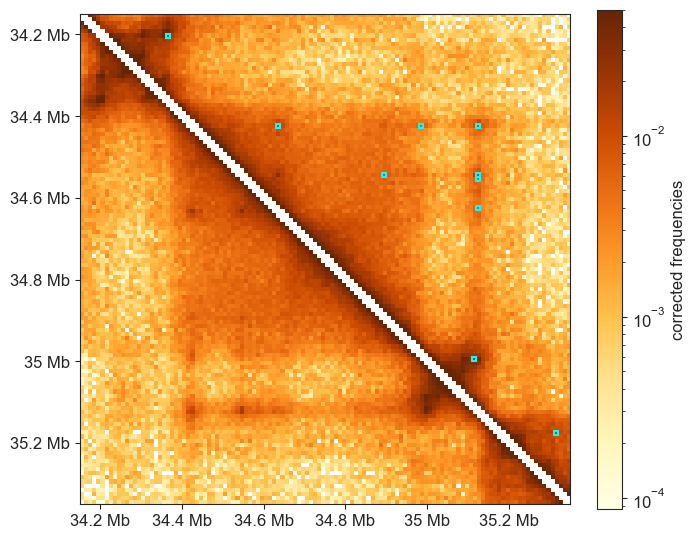

In [71]:
# define a region to look into as an example
start = 34_150_000
end = start + 1_200_000
region = ('chr17', start, end)

# heatmap kwargs
matshow_kwargs = dict(
    cmap='YlOrBr',
    norm=LogNorm(vmax=0.05),
    extent=(start, end, end, start)
)

# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')

# compute heatmap for the region
region_matrix = clr.matrix(balance=True).fetch(region)
for diag in [-1,0,1]:
    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow( region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df, region, lw=1.5):
    ax.add_patch(box)


#### FANC: dots

In [72]:
import fanc.peaks

In [73]:
fanc_hic = fanc_hic10k

In [74]:
# loop_caller = fanc.RaoPeakCaller()
# loop_info = loop_caller.call_peaks(fanc_hic)

In [75]:
# for edge in loop_info.peaks(lazy=True):
#     print(edge.oe_d, edge.fdr_d)

In [76]:
# # regular Hi-C
# p_hic = fancplot.TriangularMatrixPlot(loop_info, vmin=0, vmax=0.05,
#                                       max_dist=600000)
# # Donut O/E values
# p_oe_d = fancplot.TriangularMatrixPlot(loop_info, vmin=0, vmax=4,
#                                        weight_field='oe_d', colormap='Reds',
#                                        max_dist=600000)
# # Donut FDR values
# p_fdr_d = fancplot.TriangularMatrixPlot(loop_info, vmin=0, vmax=0.1,
#                                         weight_field='fdr_d', colormap='binary_r',
#                                         max_dist=600000)

# gf = fancplot.GenomicFigure([p_hic, p_oe_d, p_fdr_d], ticks_last=True)
# fig, axes = gf.plot('chr17:34.15mb-35.35mb')

In [77]:
# # filter on O/E
# enrichment_filter = fanc.peaks.EnrichmentPeakFilter(
#         enrichment_ll_cutoff=1.75,
#         enrichment_d_cutoff=3,
#         enrichment_h_cutoff=2,
#         enrichment_v_cutoff=2)
# loop_info.filter(enrichment_filter, queue=True)

# # filter on FDR
# fdr_filter = fanc.peaks.FdrPeakFilter(
#     fdr_ll_cutoff=0.05,
#     fdr_d_cutoff=0.05,
#     fdr_h_cutoff=0.05,
#     fdr_v_cutoff=0.05)
# loop_info.filter(fdr_filter, queue=True)

# # filter on mappability
# mappability_filter = fanc.peaks.MappabilityPeakFilter(
#     mappability_ll_cutoff=0.7,
#     mappability_d_cutoff=0.7,
#     mappability_h_cutoff=0.7,
#     mappability_v_cutoff=0.7)
# loop_info.filter(mappability_filter, queue=True)

# # filter on distance from diagonal
# distance_filter = fanc.peaks.DistancePeakFilter(5)
# loop_info.filter(distance_filter, queue=True)

# # filter on minimum number of observed values
# observed_filter = fanc.peaks.ObservedPeakFilter(10)
# loop_info.filter(observed_filter, queue=True)

# loop_info.run_queued_filters()

In [78]:
# # Merge pixels
# merged_peaks = loop_info.merged_peaks()

In [79]:
# singlet_filter = fanc.peaks.RaoMergedPeakFilter(cutoff=-1)
# merged_peaks.filter(singlet_filter)

In [80]:
# merged_peaks.to_bedpe("architecture/loops/rao2014.chr11_77400000_78600000.bedpe")

# Plotting time and memory benchmarks

In [81]:
df_timings = pd.DataFrame(timings, columns=['test', 'tool', 'resolution', 'nproc', 'time_mean_s', 'memory_Mb'])

df_timings.loc[:, 'time_mean_ms'] = 1000 * df_timings['time_mean_s']
df_timings.loc[:, 'log10(time_ms)'] = np.log10(df_timings['time_mean_ms'])

df_timings.loc[:, 'memory_Kb'] = 1024 * df_timings['memory_Mb']
df_timings.loc[:, 'log10(memory_Kb)'] = np.log10(df_timings['memory_Kb'])

In [82]:
df_timings.to_csv("cooltools-vs-fanc_performance.csv")

In [83]:
df_timings

,test,tool,resolution,nproc,time_mean_s,memory_Mb,time_mean_ms,log10(time_ms),memory_Kb,log10(memory_Kb)
0,expected,cooltools,1000,1,31.513790,2649.241211,31513.789752,4.498501,2712823.0,6.433421
1,expected,cooltools,10000,1,9.159674,2480.441406,9159.673560,3.961880,2539972.0,6.404829
2,expected,cooltools,100000,1,0.913997,681.265625,913.997315,2.960945,697616.0,5.843616
3,expected,cooltools,1000000,1,0.062929,28.492188,62.928889,1.798850,29176.0,4.465026
4,expected,fanc,1000,1,306.912301,2934.079102,306912.300618,5.487014,3004497.0,6.477772
5,expected,fanc,10000,1,81.799918,990.093750,81799.917551,4.912753,1013856.0,6.005976
6,expected,fanc,100000,1,10.956462,247.037109,10956.462141,4.039670,252966.0,5.403062
7,expected,fanc,1000000,1,0.246652,23.183594,246.652493,2.392086,23740.0,4.375481
8,insulation,cooltools,1000,1,37.521444,2185.202148,37521.443628,4.574280,2237647.0,6.349792
9,insulation,cooltools,10000,1,1.205776,800.339844,1205.776414,3.081267,819548.0,5.913574


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

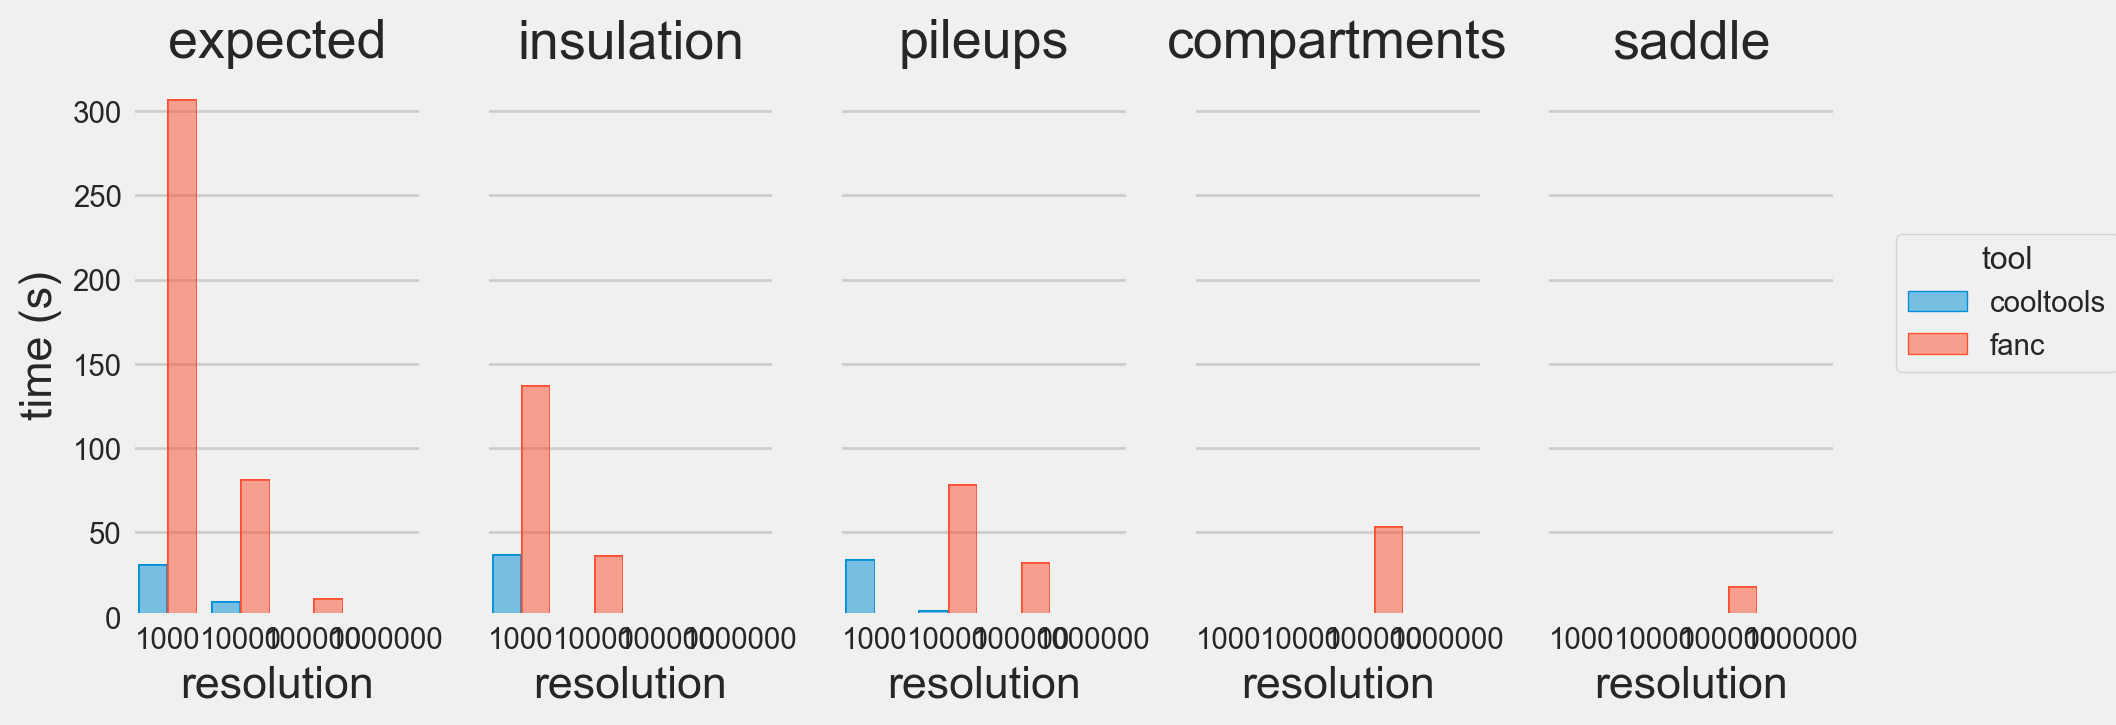

In [84]:
p = (
    so.Plot(df_timings, x="resolution", y="time_mean_s", color="tool").layout(size=(10, 4))
        .add(so.Bar(alpha=.5), so.Agg(), so.Dodge())
    )
(
    p.theme(style.library["fivethirtyeight"])
    .facet("test")
    .scale(x=so.Nominal())
    .label(y='time (s)')
    .save("./benchmark_cool-vs-fan_time_s.pdf")
)



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

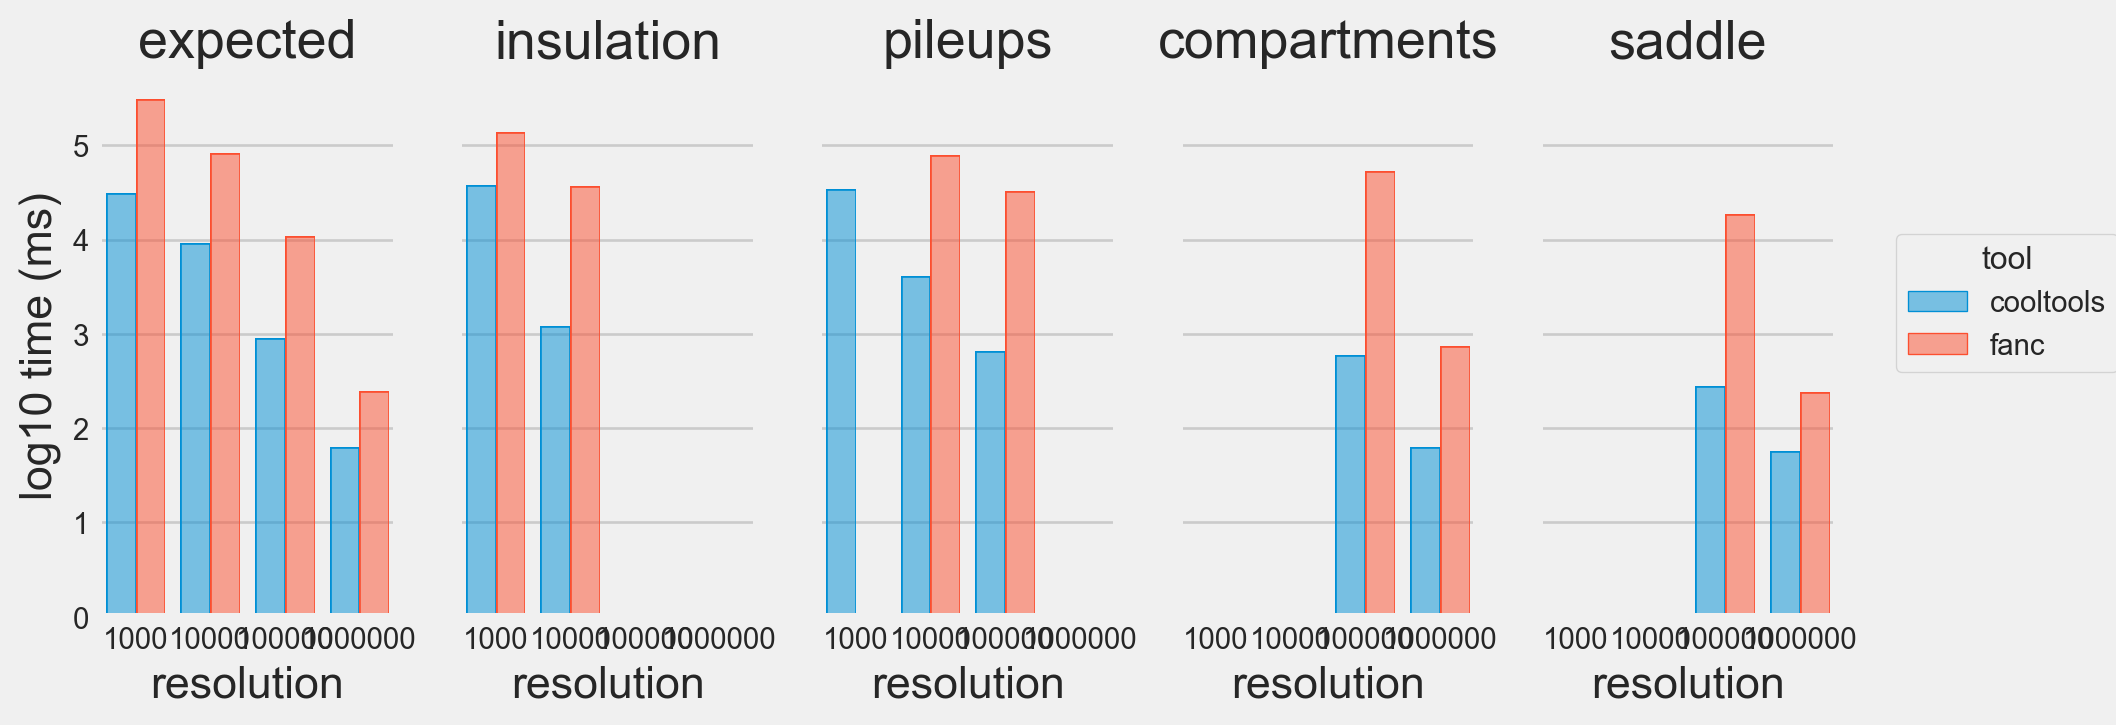

In [85]:
p = (
    so.Plot(df_timings, x="resolution", y="log10(time_ms)", color="tool").layout(size=(10, 4))
        .add(so.Bar(alpha=.5), so.Agg(), so.Dodge())
    )
(
    p.theme(style.library["fivethirtyeight"])
    .facet("test")
    .scale(x=so.Nominal())
    .label(y='log10 time (ms)')
    .save("./benchmark_cool-vs-fan_log_time_ms.pdf")
)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

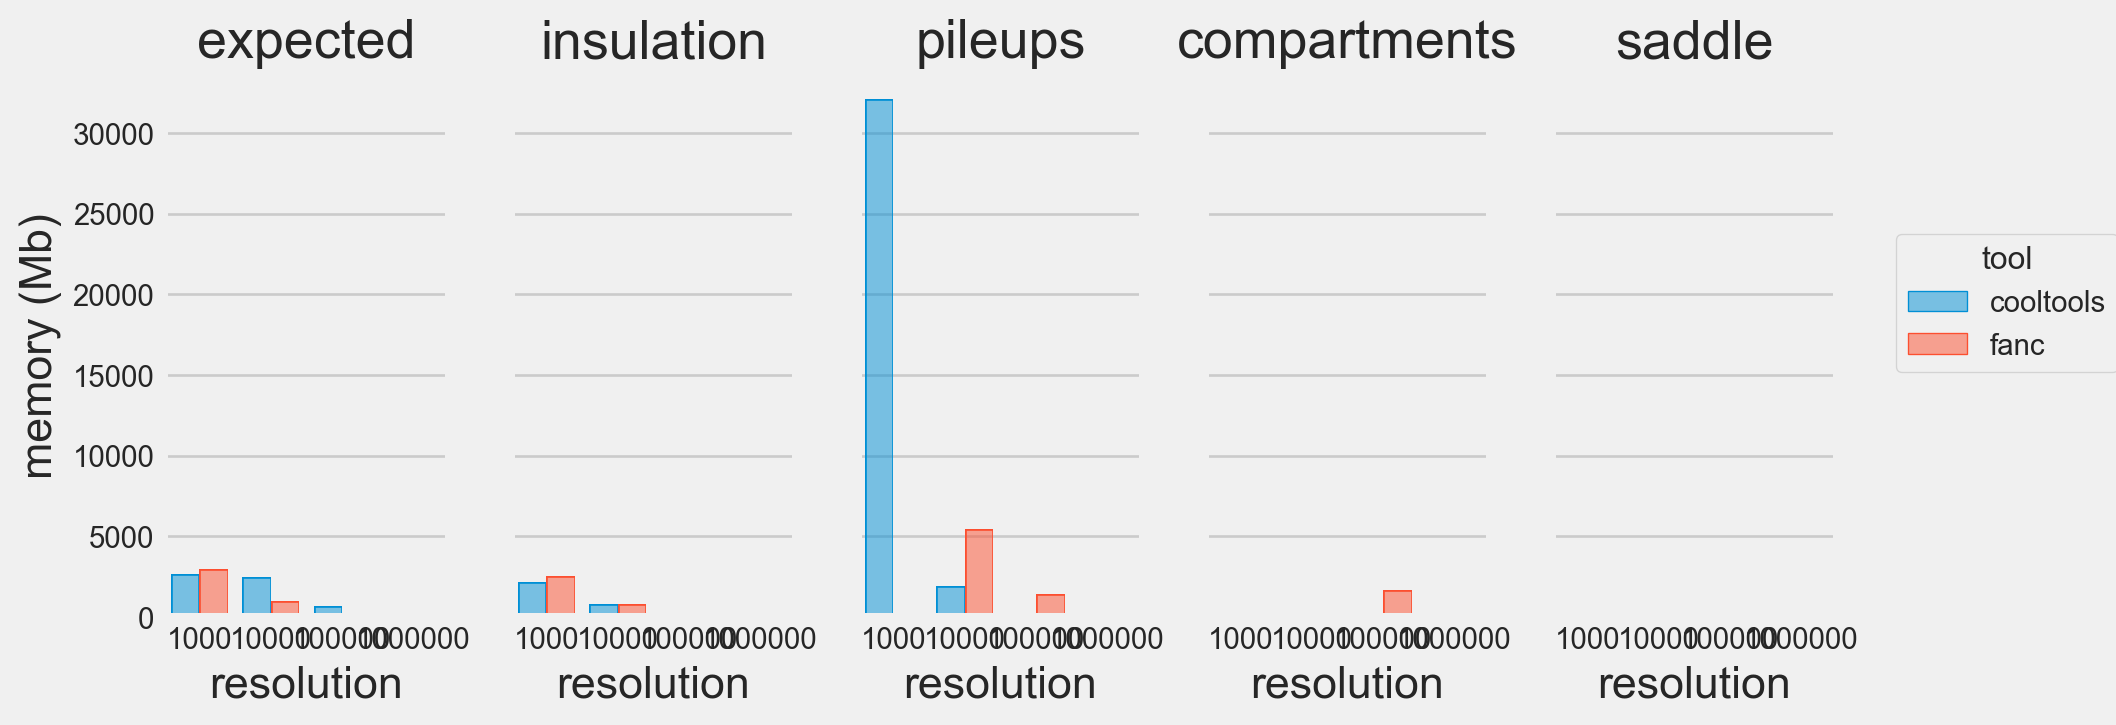

In [86]:
p = (
    so.Plot(df_timings, x="resolution", y="memory_Mb", color="tool").layout(size=(10, 4))
        .add(so.Bar(alpha=.5), so.Agg(), so.Dodge())
    )
(
    p.theme(style.library["fivethirtyeight"])
    .facet("test")
    .scale(x=so.Nominal())
    .label(y='memory (Mb)')
    .save("./benchmark_cool-vs-fan_memory_mb.pdf")
)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

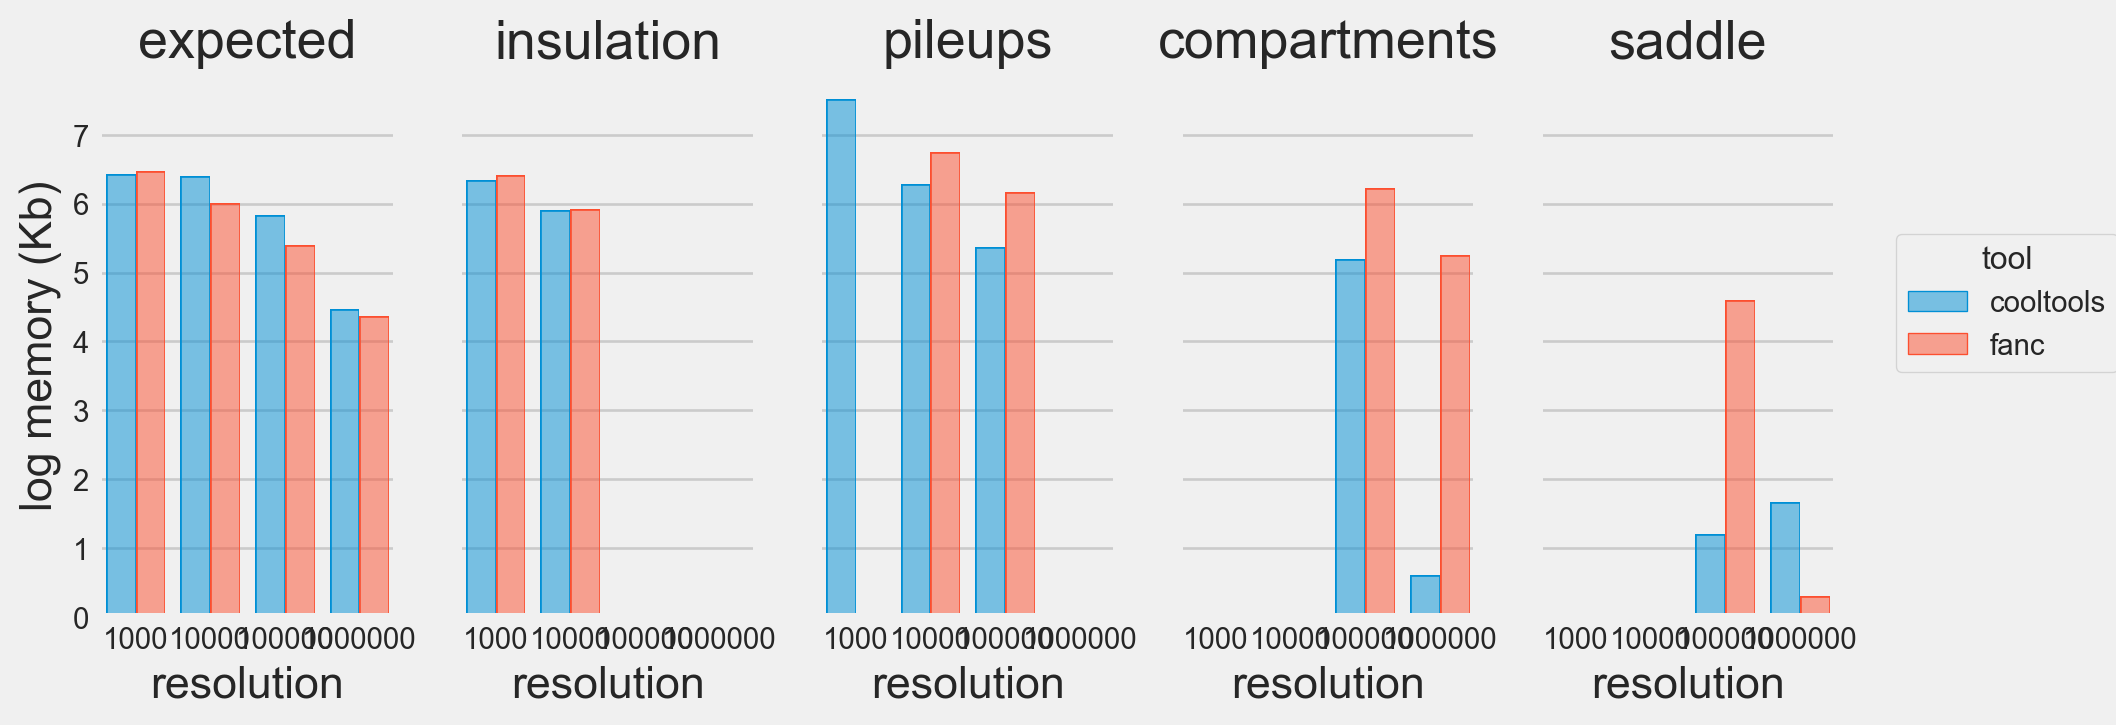

In [87]:
p = (
    so.Plot(df_timings, x="resolution", y="log10(memory_Kb)", color="tool").layout(size=(10, 4))
        .add(so.Bar(alpha=.5), so.Agg(), so.Dodge())
    )
(
    p.theme(style.library["fivethirtyeight"])
    .facet("test")
    .scale(x=so.Nominal())
    .label(y='log memory (Kb)')
    .save("./benchmark_cool-vs-fan_log_memory_kb.pdf")
)